In [1]:
import pandas as pd
import numpy as np

# modeling
import keras
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info

traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [3]:
traffic_df.shape

(29984, 449)

## Alternative 2: Adding pollution features


In [4]:
pollution_df = pd.read_csv("../data/aarhus_pollution_data_aug_oct_2014.csv")
pollution_df['timestamp'] = pd.to_datetime(pollution_df['timestamp'])
pollution_df.set_index('timestamp', inplace=True)
pollution_df.head()

,Unnamed: 0,ozone,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide,longitude,latitude
timestamp,,,,,,,,
2014-08-01 00:05:00,0,101,94,49,44,87,10.104986,56.231721
2014-08-01 00:10:00,1,106,97,48,47,86,10.104986,56.231721
2014-08-01 00:15:00,2,107,95,49,42,85,10.104986,56.231721
2014-08-01 00:20:00,3,103,90,51,44,87,10.104986,56.231721
2014-08-01 00:25:00,4,105,94,49,39,82,10.104986,56.231721


In [5]:
pollution_features = ["particullate_matter", "carbon_monoxide", "sulfure_dioxide", "nitrogen_dioxide"]
# Merge using nearest timestamps 
combined_pollution_traffic = pd.merge_asof(
    traffic_df.sort_index(),
    pollution_df[pollution_features].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest'
)

combined_pollution_traffic

,610,611,612,613,614,615,616,617,618,619,...,1053,1054,1055,1056,1057,1058,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,19.0,48.0,34.0,0.0,65.0,32.000000,43,49,39,90
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,21.0,69.0,34.0,0.0,69.0,32.000000,33,86,76,73
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,21.0,70.0,36.0,0.0,67.0,28.000000,31,34,68,123
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,56.0,46.0,0.0,58.0,28.000000,91,37,79,106
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,51.0,46.0,0.0,60.0,27.666667,31,39,48,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-13 10:25:00,42.0,12.0,52.0,40.0,33.0,52.5,45.0,36.5,30.0,44.0,...,0.0,60.0,48.0,44.0,63.0,26.000000,190,193,126,105
2014-11-13 10:30:00,42.0,12.0,52.0,32.0,33.0,75.0,40.0,37.0,29.0,44.0,...,0.0,70.0,41.0,44.0,63.0,23.000000,190,193,126,105
2014-11-13 10:35:00,50.0,12.0,44.0,36.0,41.0,49.0,55.0,37.0,35.0,44.0,...,0.0,69.0,42.0,44.0,65.0,23.000000,190,193,126,105


In [6]:
training_sample = combined_pollution_traffic[100:20000]
validation_sample = combined_pollution_traffic[20001:]

combined_pollution_traffic.shape

(29984, 453)

In [7]:
def create_sequence_training_set(training_sample, seq_length, pred_horizon, input_features, output_features):
    seq_arrays = []
    seq_labs = []
    for i in range(training_sample.shape[0] - seq_length - pred_horizon):
        seq_arrays.append(training_sample.iloc[i:seq_length+i, :input_features].to_numpy())
        seq_labs.append(training_sample.iloc[seq_length+pred_horizon+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)
    return seq_arrays, seq_labs

# create validation dataset
def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []
    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(validation_sample.iloc[:(i+1), :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[:(i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(val_arrays, padding='pre', dtype=object).astype(np.float32)
    val_labs = np.array(val_labs, dtype=object).astype(np.float32)
    return val_arrays, val_labs


In [8]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 

input_features = 453 
output_features = 449

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(training_sample, seq_length, ph,input_features, output_features)

val_arrays, val_labs = create_validation_set(validation_sample, seq_length, ph, input_features, output_features)

In [9]:
def train_lstm_model(model_path, seq_length, seq_arrays, seq_labs, input_features, output_features):
# define path to save model
    model_path = model_path

    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features), 
        units=100, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))
    model.add(LSTM( units=32, activation="relu", return_sequences=False))
    model.add(Dense(units=output_size, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=80,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

    return model, history



In [10]:


model, history = train_lstm_model('../models/lstm_traffic_pollution.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features, 
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │       221,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,073 (1.11 MB)

 Trainable params: 291,073 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
237/237 - 7s - 31ms/step - loss: 790.6166 - mse: 790.6166 - val_loss: 234.3151 - val_mse: 234.3151
Epoch 2/1000
237/237 - 6s - 24ms/step - loss: 188.8116 - mse: 188.8116 - val_loss: 232.9489 - val_mse: 232.9489
Epoch 3/1000
237/237 - 6s - 25ms/step - loss: 181.6526 - mse: 181.6526 - val_loss: 224.8289 - val_mse: 224.8289
Epoch 4/1000
237/237 - 6s - 26ms/step - loss: 178.6955 - mse: 178.6955 - val_loss: 230.6373 - val_mse: 230.6373
Epoch 5/1000
237/237 - 7s - 28ms/step - loss: 182.5811 - mse: 182.5811 - val_loss: 227.1047 - val_mse: 227.1047
Epoch 6/1000
237/237 - 6s - 27ms/step - loss: 176.6648 - mse: 176.6648 - val_loss: 223.9883 - val_mse: 223.9883
Epoch 7/1000
237/237 - 6s - 26ms/step - loss: 175.2749 - mse: 175.2749 - val_loss: 221.9116 - val_mse: 221.9116
Epoch 8/1000
237/237 - 6s - 27ms/step - loss: 173.7969 - mse: 173.7969 - val_loss: 209.6403 - val_mse: 209.6403
Epoch 9/1000
237/237 - 6s - 26ms/step - loss: 172.2388 - mse: 172.2388 - val_loss: 194.7680 - val_m

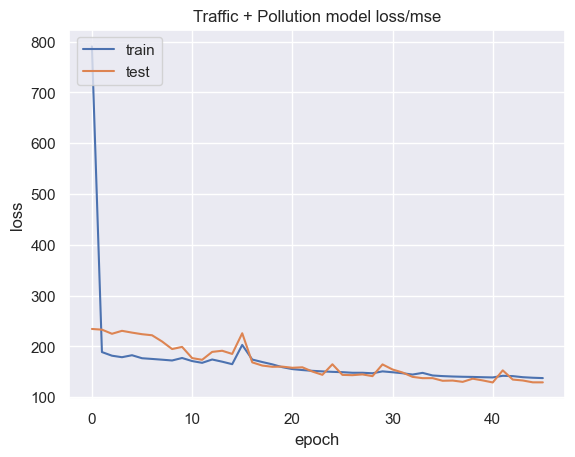

312/312 - 2s - 5ms/step - loss: 169.1529 - mse: 169.1529

MSE: 169.1528778076172


In [11]:
def summarize_history_loss(history, title):
    # summarize history for Loss/MSE
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, "Traffic + Pollution model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


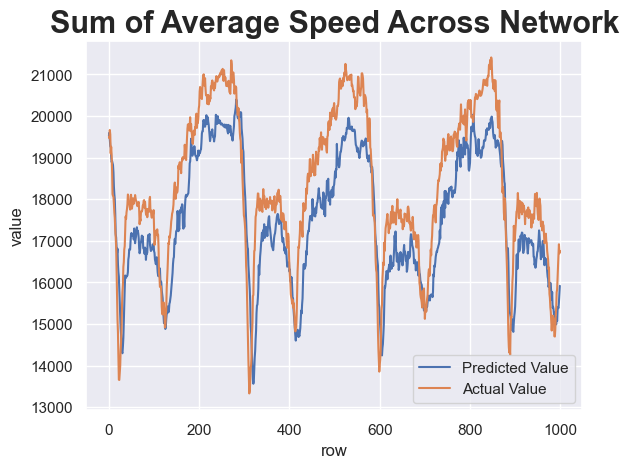

In [12]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 5000
    ts = 1000

    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Average Speed Across Network')